# Imports

In [1]:
# Core
import os
import sys
import re
import datetime as dt
from typing import List, Dict, Tuple, Any, Optional, Union
import logging
from dataclasses import dataclass, field

# Data analysis
import numpy as np
import pandas as pd

# Visalization
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import seaborn as sns

# Fitting distributions
import scipy.stats
from fitter import Fitter

from distribution_fitter import *
from utils import *

In [2]:
logging.basicConfig(level=logging.DEBUG)

# Reading the data

In [3]:
# Helper function to read all the historic dataframes from a path
def read_files(path: str) -> pd.DataFrame:
    files = os.listdir(path)
    files = [os.path.join(path, file) for file in files if re.search(".csv", file)]
    dfs = list(map(lambda file: pd.read_csv(file, low_memory=False), files))
    return pd.concat(dfs)

In [4]:
mlb_df = read_files("data/MLB/")

In [5]:
mlb_df.columns

Index(['game_info__bigdataball_dataset', 'game_info__game_id',
       'game_info__date', 'player_info__player_id', 'player_info__player_name',
       'player_info__team', 'player_info__opponent', 'player_info__venue',
       'position__draftkings', 'position__fanduel', 'position__yahoo',
       'salary__draftkings', 'salary__fanduel', 'salary__yahoo',
       'fantasy_points__draftkings', 'fantasy_points__fanduel',
       'fantasy_points__yahoo'],
      dtype='object')

In [6]:
mlb_df.dtypes

game_info__bigdataball_dataset     object
game_info__game_id                 object
game_info__date                    object
player_info__player_id            float64
player_info__player_name           object
player_info__team                  object
player_info__opponent              object
player_info__venue                 object
position__draftkings               object
position__fanduel                  object
position__yahoo                    object
salary__draftkings                 object
salary__fanduel                   float64
salary__yahoo                     float64
fantasy_points__draftkings         object
fantasy_points__fanduel            object
fantasy_points__yahoo              object
dtype: object

# Cleaning data

In [7]:
mlb_df.game_info__bigdataball_dataset.value_counts()

game_info__bigdataball_dataset
MLB 2019 Regular Season    71681
MLB 2021 Regular Season    71619
MLB 2022 Regular Season    70931
MLB 2020 Regular Season    26720
MLB 2020 Playoffs           1692
MLB 2021 Playoffs           1213
MLB 2022 Playoffs           1207
MLB 2019 Playoffs           1138
Name: count, dtype: int64

In [8]:
def with_season_type(game_type: str) -> str:
    return "regular-season" if re.search("Season", game_type) else "playoffs"

In [9]:
def format_date(date_str: str) -> dt.datetime:
    try:
        _date = dt.datetime.strptime(date_str, "%d/%m/%Y")
    except ValueError:
        _date = dt.datetime.strptime(date_str, "%m/%d/%Y")
    return _date

In [10]:
cleaned_mlb_df = mlb_df.assign(
    game_info__date=pd.to_datetime(mlb_df.game_info__date.apply(format_date)),
    fantasy_points__draftkings=mlb_df.fantasy_points__draftkings.apply(lambda s: float(str(s).replace(",","."))),
    fantasy_points__fanduel=mlb_df.fantasy_points__fanduel.apply(lambda s: float(str(s).replace(",","."))),
    fantasy_points__yahoo=mlb_df.fantasy_points__yahoo.apply(lambda s: float(str(s).replace(",","."))),
    game_info__game_type=mlb_df.game_info__bigdataball_dataset.apply(with_season_type)
)

# Fitting distributions

## By player

In [11]:
def get_frequencies(df: pd.DataFrame, groupby_keys: List[str]) -> pd.DataFrame:
    frequency_df = df.groupby(groupby_keys).size().reset_index(name='frequency')
    frequency_df = frequency_df.sort_values(by=['frequency'], ascending=False)
    return frequency_df

In [12]:
def plot_distribution_by_variable(df: pd.DataFrame, variable: str, xlabel: str, ylabel: str) -> None:
    
    fig, ax = plt.subplots(ncols=2, figsize=(20, 6))
    
    sns.histplot(data=df, x=variable, kde=True, ax=ax[0])
    ax[0].set_ylabel(ylabel)
    ax[0].set_xlabel(xlabel)
    
    sns.boxplot(data=df, x=variable, orient='h', ax=ax[1])
    sns.stripplot(data=df, x=variable, orient='h', color=".25", ax=ax[1])
    
    ax[1].tick_params(axis='y', which='both', left=False, top=False, labelleft=False)
    ax[1].set_xlabel(xlabel)
    
    fig.suptitle(f'Distribution of: {xlabel.lower()} by {ylabel.lower()}')
    
    plt.plot();

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/opt/miniconda3/envs/statistical-simulation/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymBol.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/opt/miniconda3/envs/statistical-simulation/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname=

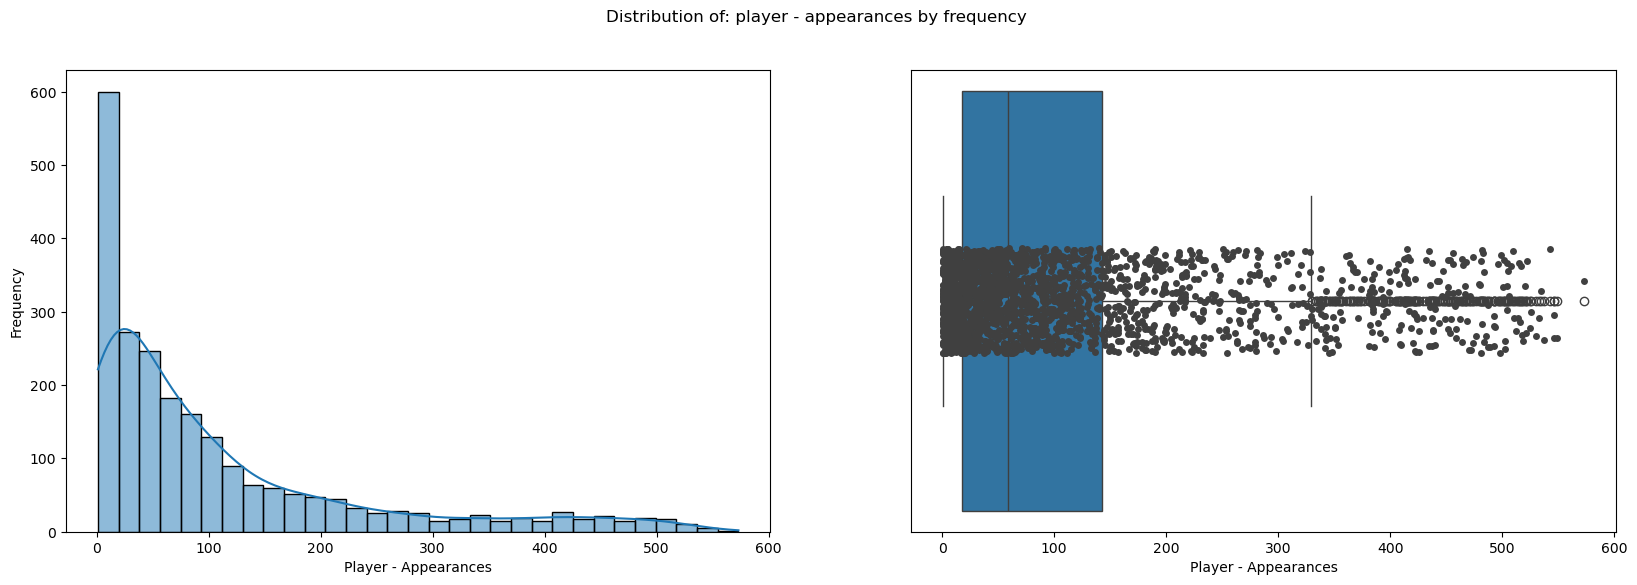

In [13]:
plot_distribution_by_variable(get_frequencies(cleaned_mlb_df, ["player_info__player_id"]), "frequency", "Player - Appearances", "Frequency")

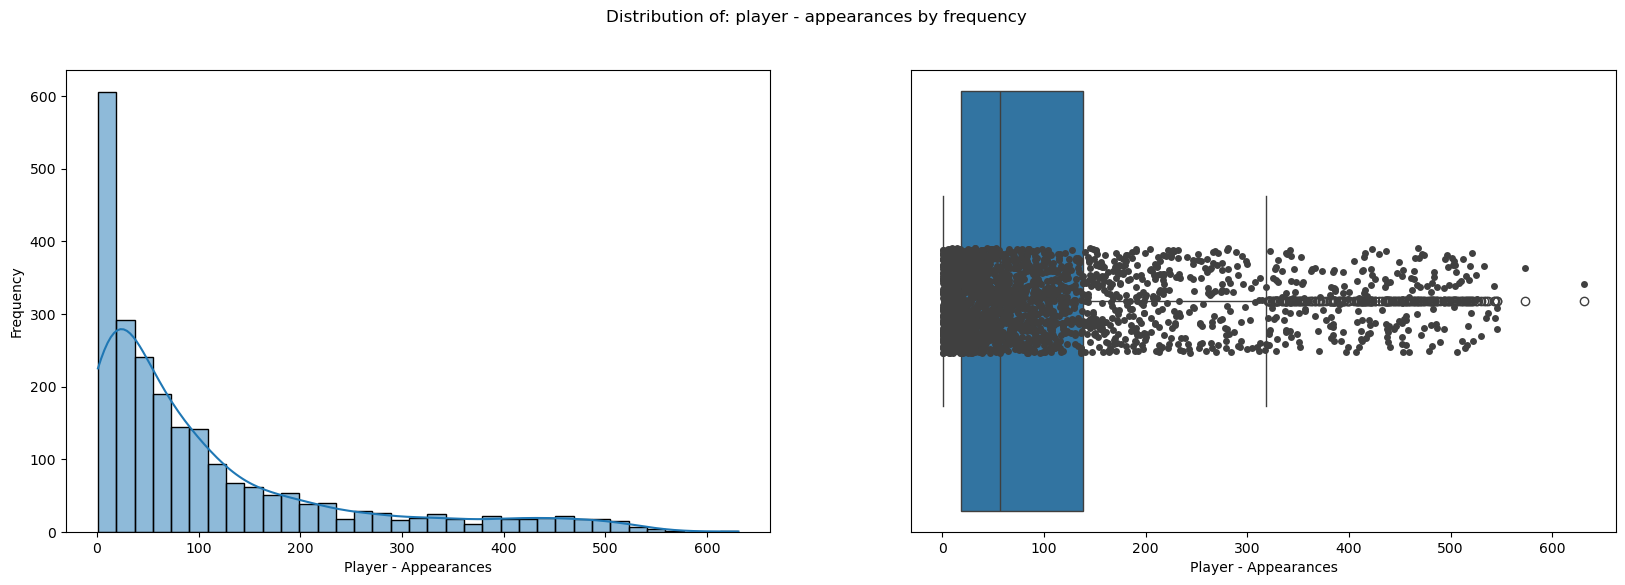

In [14]:
plot_distribution_by_variable(get_frequencies(cleaned_mlb_df, ["player_info__player_name"]), "frequency", "Player - Appearances", "Frequency")

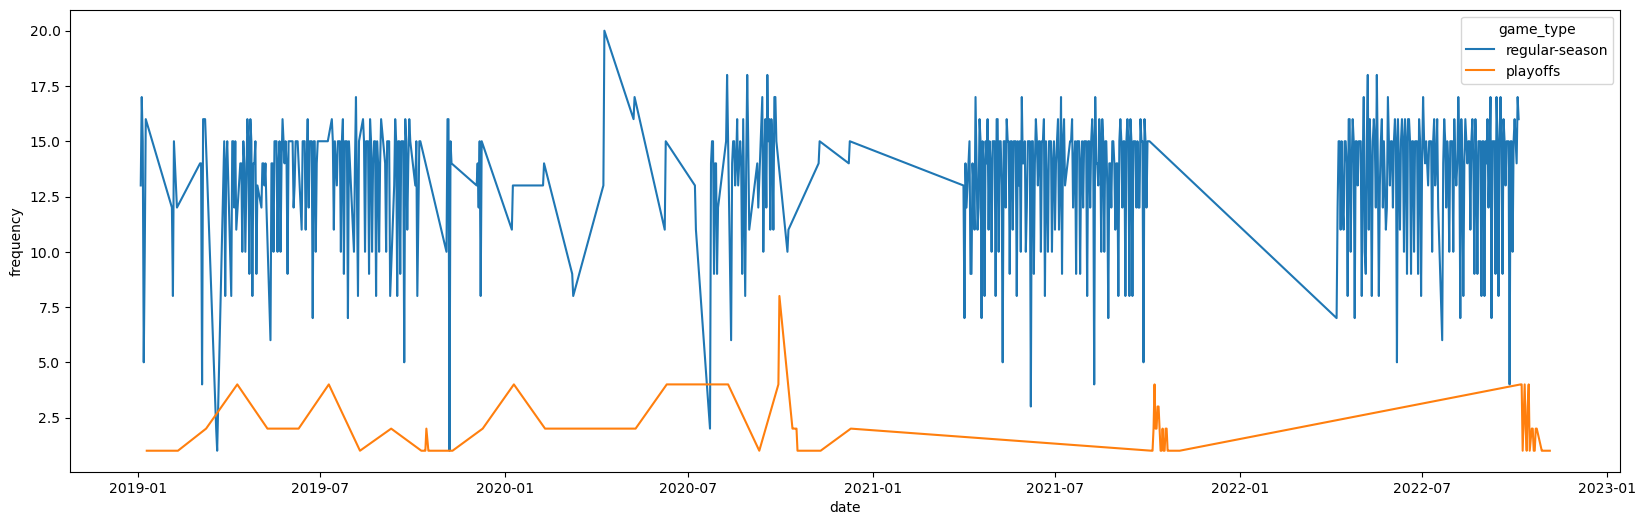

In [15]:
games_per_date = cleaned_mlb_df[["game_info__game_type", "game_info__game_id", "game_info__date"]].drop_duplicates()\
.groupby(["game_info__date", "game_info__game_type"])\
.size()\
.reset_index(name='frequency')\
.rename(columns={"game_info__date": "date", "game_info__game_type": "game_type"})

fig, ax = plt.subplots(figsize=(20, 6))

sns.lineplot(
    data=games_per_date,
    x="date",
    y="frequency",
    hue="game_type",
    ax=ax
)

plt.plot();

In [16]:
def plot_histogram(
    df: pd.DataFrame, 
    filter_column: str, 
    factor: Any, 
    value: str,
    kde: bool = False
) -> Figure:
    fig, ax = plt.subplots(ncols=1, figsize=(16, 8))

    sns.histplot(
        data=df[
        (df[filter_column] == factor) & (~df[value].isna())
        ], 
        x=value, 
        kde=kde,
        bins=100
    )
    ax.set_ylabel('Frecuency')
    ax.set_xlabel(" - ".join(value.split("__")))

    fig.suptitle(f'Distribution of: {value} by factor: {factor}')

    return fig

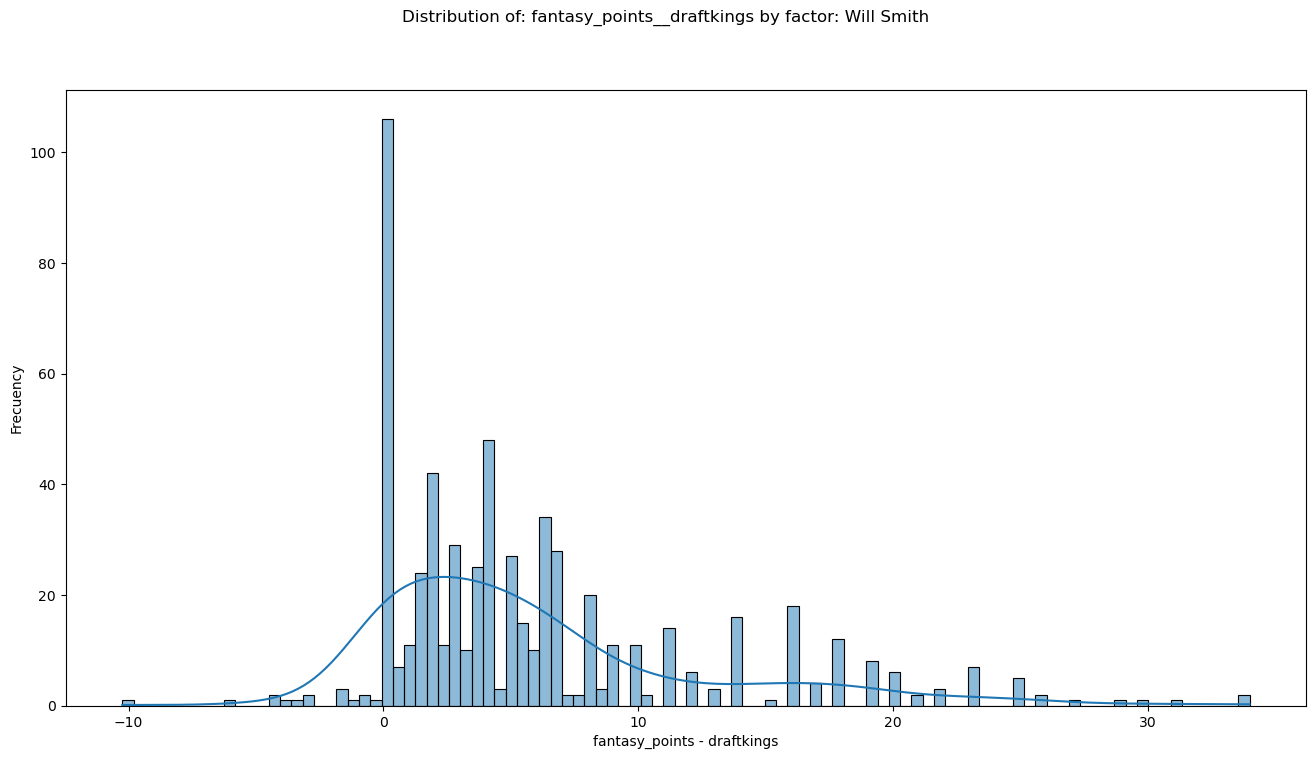

In [17]:
fig = plot_histogram(cleaned_mlb_df, "player_info__player_name", "Will Smith", "fantasy_points__draftkings", True)

## Position

In [18]:
get_frequencies(cleaned_mlb_df, ["position__fanduel"])

,position__fanduel,frequency
52,P,69587
42,OF,58807
31,C,19887
1,1B,17444
53,SS,15615
20,3B,15597
10,2B,14718
18,2B/SS,4035
17,2B/OF,2877
22,3B/2B,2163


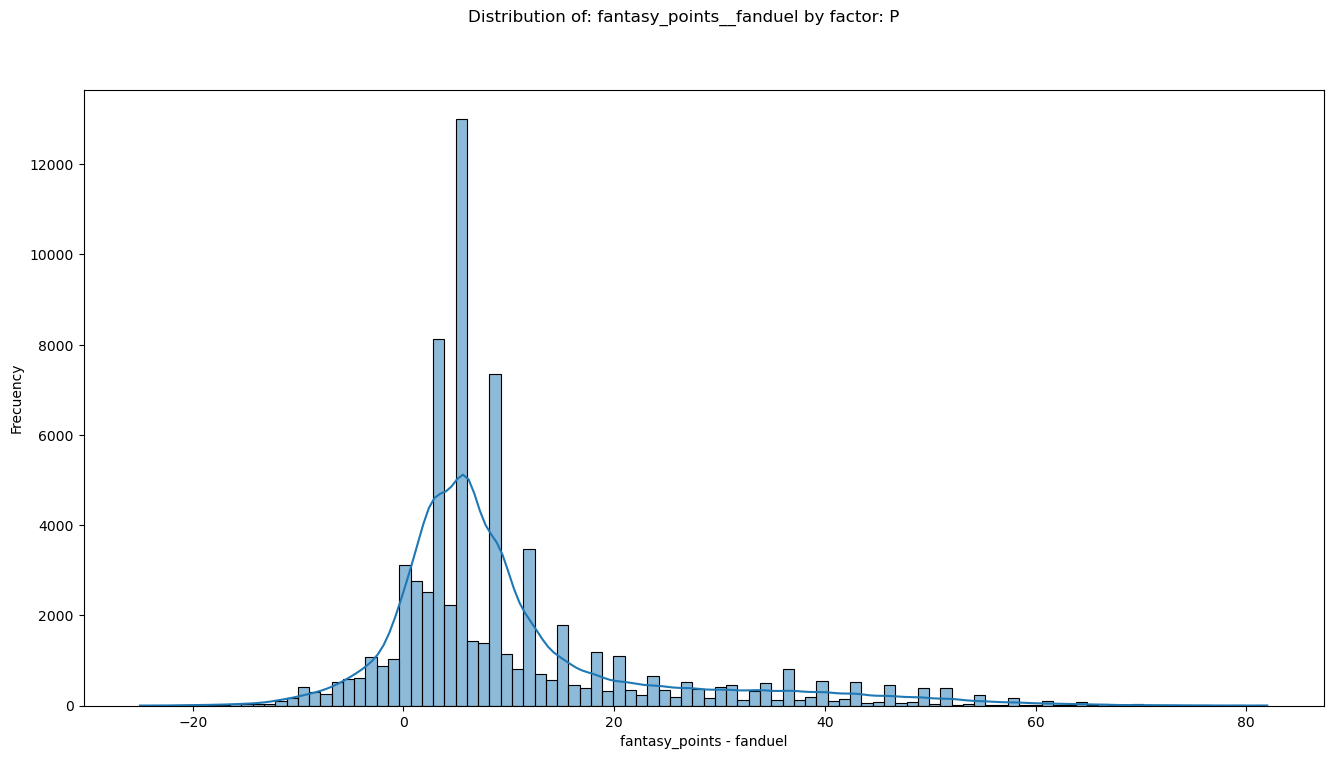

In [19]:
fig = plot_histogram(cleaned_mlb_df, "position__fanduel", "P", "fantasy_points__fanduel", True)

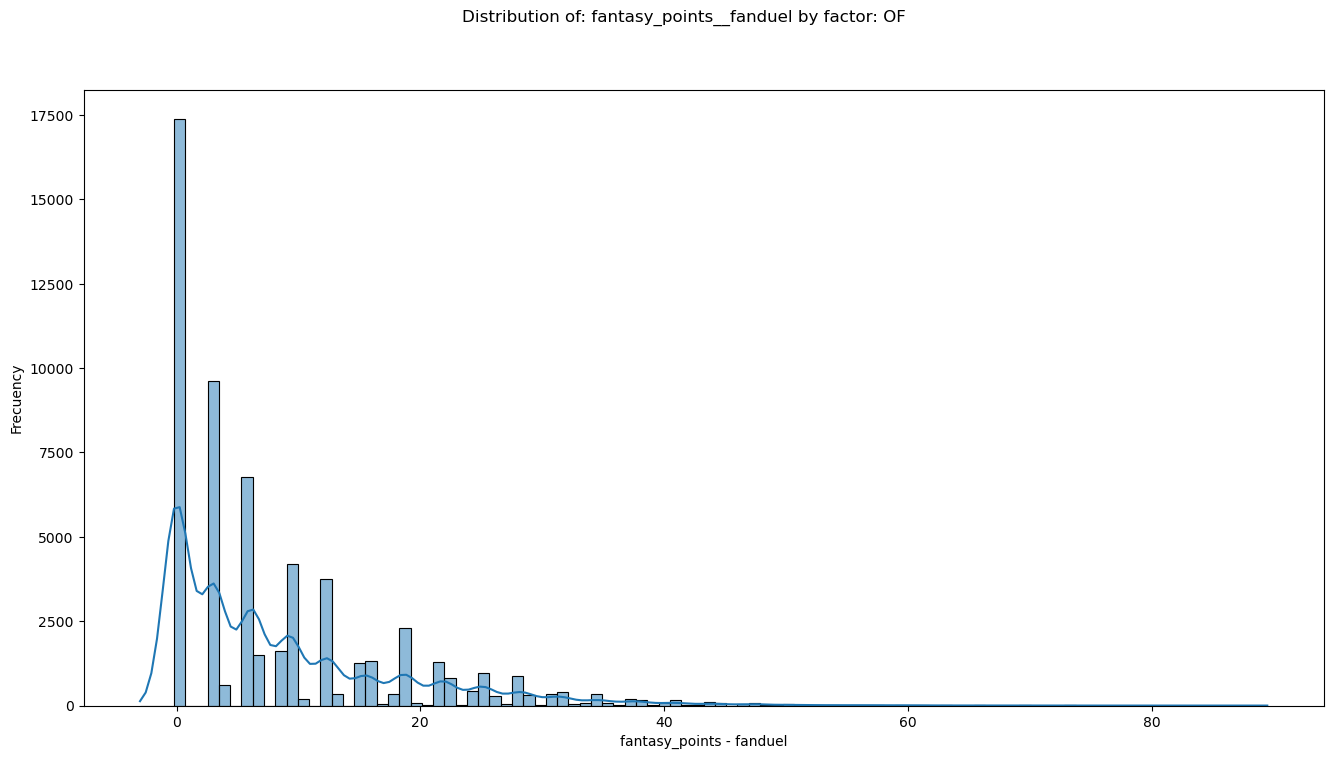

In [20]:
fig = plot_histogram(cleaned_mlb_df, "position__fanduel", "OF", "fantasy_points__fanduel", True)

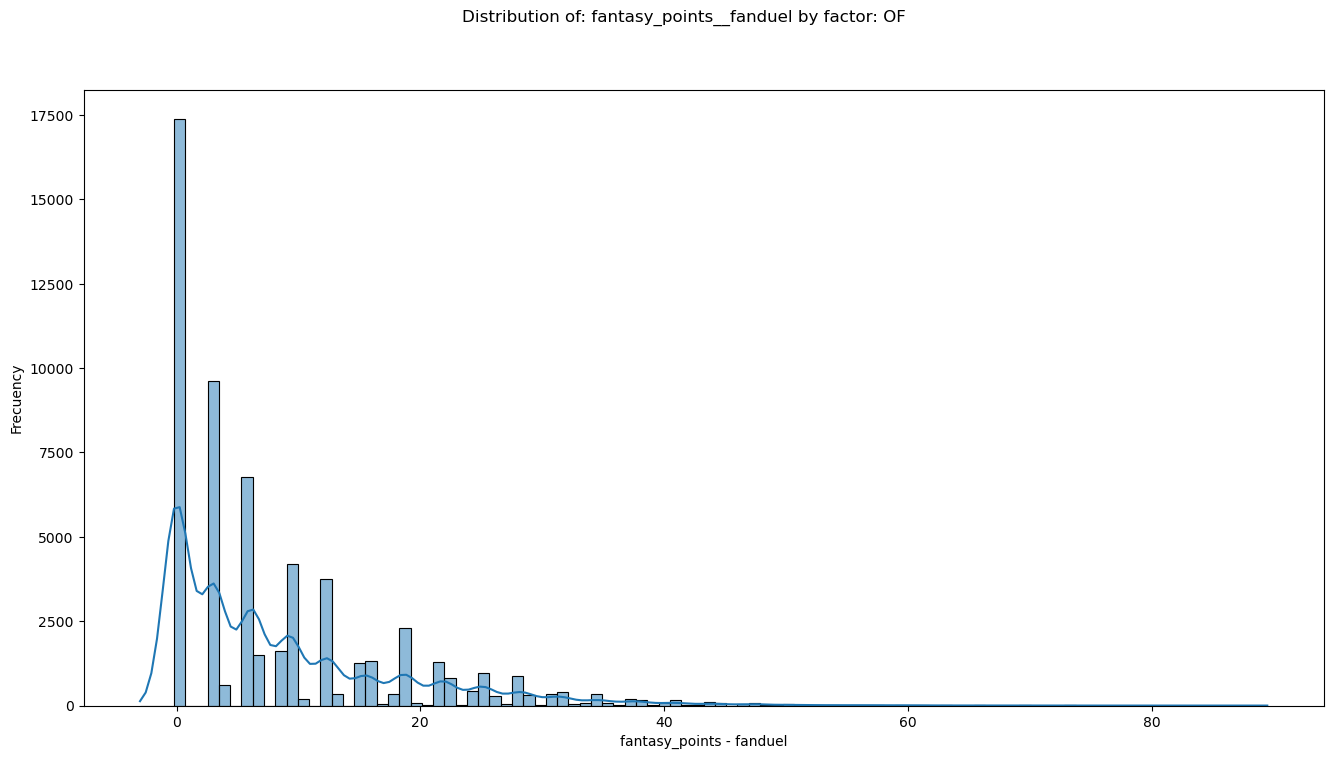

In [21]:
fig = plot_histogram(cleaned_mlb_df, "position__fanduel", "OF", "fantasy_points__fanduel", True)

# Distributions fitting process

In [22]:
data = cleaned_mlb_df[
(cleaned_mlb_df.position__draftkings == "P") & 
(~cleaned_mlb_df['fantasy_points__fanduel'].isna())
]['fantasy_points__fanduel']

In [23]:
distribution_fitter = DistributionFitter(distributions=get_distributions(), bins=sturges_bins(data))

In [24]:
get_common_distributions()

['cauchy',
 'chi2',
 'expon',
 'exponpow',
 'gamma',
 'lognorm',
 'norm',
 'powerlaw',
 'rayleigh',
 'uniform']

In [25]:
distribution_fitter.fit(data)

INFO:distribution_fitter:Fitting distribution: alpha
INFO:distribution_fitter:Fitting distribution: anglit
INFO:distribution_fitter:Fitting distribution: arcsine
INFO:distribution_fitter:Fitting distribution: argus
INFO:distribution_fitter:Fitting distribution: beta
/opt/miniconda3/envs/statistical-simulation/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
INFO:distribution_fitter:Fitting distribution: betaprime
INFO:distribution_fitter:Fitting distribution: bradford
INFO:distribution_fitter:Fitting distribution: burr
INFO:distribution_fitter:Fitting distribution: burr12
INFO:distribution_fitter:Fitting distribution: cauchy
INFO:distribution_fitter:Fitting distribution: chi
INFO:distribution_fitter:Fitting distribution: chi2
INFO:distribution_fitter:Fitting distribution: cosine
INFO:distribution_fitter:Fitting distribution: crystalball
INFO:distribution_fi

KeyboardInterrupt: 

In [ ]:
distribution_fitter.summary()

distribution = "norm"

fitted_params: DistributionParameters = distribution_fitter.fit_single_distribution(
    data=data, distribution_name=distribution
)

fitted_pdf: np.ndarray = distribution_fitter.get_pdf(data, distribution, fitted_params)

goodness_of_fit_metrics: DistributionFitterResult = distribution_fitter.get_goodness_of_fit_metrics(
    data=data, params=fitted_params, fitted_pdf=fitted_pdf, distribution_name=distribution, 
)

goodness_of_fit_metrics

f = Fitter(
    cleaned_mlb_df[cleaned_mlb_df.position__draftkings == "P"]['fantasy_points__draftkings'], 
    distributions=get_common_distributions(), 
    timeout=180
)

f.fit()

f.summary()

f.fitted_param

f.plot_pdf()

get_common_distributions()

f.get_best()

name = "cauchy"

params = f.fitted_param[name]

distribution = getattr(stats, name)
param_names = (distribution.shapes + ", loc, scale").split(", ") if distribution.shapes else ["loc", "scale"]


param_dict = {}
for d_key, d_val in zip(param_names, params):
    param_dict[d_key] = d_val
param_dict

cleaned_mlb_2022_df[cleaned_mlb_2022_df.position__draftkings == "P"]['fantasy_points__draftkings']

random_samples = stats.cauchy.rvs(**{'loc': 3.5516552486283928, 'scale': 2.8333898689614676}, size=17992)

random_samples

qq_plot_df = pd.DataFrame({
    "original_data": np.sort(cleaned_mlb_2022_df[cleaned_mlb_2022_df.position__draftkings == "P"]['fantasy_points__draftkings'].values),
    "simulated_data": np.sort(random_samples)
})

sns.scatterplot(data=qq_plot_df, x="original_data", y="simulated_data")